### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [1]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')


In [2]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [3]:
import requests
from xml.etree import ElementTree as ET
from datetime import datetime
import re

# SOAP XML запрос
soap_request = f"""
<soap12:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap12="http://www.w3.org/2003/05/soap-envelope">
  <soap12:Body>
    <KeyRate xmlns="http://web.cbr.ru/">
      <fromDate>2024-01-01T00:00:00</fromDate>
      <ToDate>2024-12-31T23:59:59</ToDate>
    </KeyRate>
  </soap12:Body>
</soap12:Envelope>
"""

# Заголовки для запроса
headers = {
    'Content-Type': 'application/soap+xml; charset=utf-8',
    'Content-Length': str(len(soap_request))
}

# Отправка SOAP запроса
response = requests.post('http://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx', headers=headers, data=soap_request)

xml_data = response.content.decode('utf-8')
pattern = re.compile(r'<DT>(.*?)</DT>\s*<Rate>(.*?)</Rate>')
matches = pattern.findall(xml_data)


date_arr = []
rate_arr = []

for date, rate in matches:
    date_arr.append(date)
    rate_arr.append(rate)
    
date_arr_ymd = []

for i in range(0, len(date_arr)):
    original_string = date_arr[i]
    parsed_date = datetime.strptime(original_string, '%Y-%m-%dT%H:%M:%S%z').date()

# Преобразуем в строку в формате 'YYYY-MM-DD'
    formatted_date = parsed_date.strftime('%Y-%m-%d')
    date_arr_ymd.append(formatted_date)

# Создание словаря
rate_dict = dict(zip(date_arr_ymd, rate_arr))


# Функция для вычисления упущенной процентной прибыли
def calculate_missed_income(data_dict, df):
    df['date_only'] = pd.to_datetime(transactions['date']).dt.date.astype(str)
    df['lost_profits'] = 0.  
    
    for index, row in df.iterrows():
        date = row['date_only']
        balance = row['bal_end_of_day']

        # Если дата есть в словаре, рассчитаем упущенную прибыль
        if date in data_dict:
            key_rate = data_dict[date]
            df.at[index, 'lost_profits'] = (balance * float(key_rate) / 100 / 365)
    return df['lost_profits']

transactions['lost_profits'] = calculate_missed_income(rate_dict, transactions).fillna(0)

print(transactions['lost_profits'])

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
1171     430.154795
1172    1850.013699
1173    2735.523288
1174    1310.054795
1175     428.486301
Name: lost_profits, Length: 1176, dtype: float64


### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [4]:
import numpy as np

fees = fees.fillna(0)
# Создаем новый столбец с предыдущим балансом на конец дня

def calculate_incassation_cost(transactions, fees):

    transactions['previous_bal_end_of_day'] = transactions.groupby('ATM_ID')['bal_end_of_day'].shift(1)

    # Объединяем данные о тарифах с данными о транзакциях
    merged_df = pd.merge(transactions, fees, on='ATM_ID', how='left')

    # 1. Расчет расходов на доставку наличных
    merged_df['cash_delivery_cost'] = merged_df['cash_in'] * merged_df['CashDeliveryPercentageFee'] + merged_df['CashDeliveryFixedFee']

    merged_df['cash_delivery_cost'] = np.where(
        ~merged_df['CashDeliveryMinFee'].isna(),
        np.maximum(merged_df['cash_delivery_cost'], merged_df['CashDeliveryMinFee']),
        merged_df['cash_delivery_cost']
    )

    # 2. Расчет расходов на извлечение старой кассеты
    merged_df['cash_collection_cost'] = merged_df['previous_bal_end_of_day'] * merged_df['CashCollectionPercentageFee']

    # Если предыдущий баланс равен 0, то пересчет кассеты стоит 0
    merged_df['cash_collection_cost'] = np.where(
        merged_df['previous_bal_end_of_day'] == 0, 
        0, 
        merged_df['cash_collection_cost']
    )


    merged_df['cash_collection_cost'] = np.where(
        ~merged_df['CashCollectionMinFee'].isna(),
        np.maximum(merged_df['cash_collection_cost'], merged_df['CashCollectionMinFee']),
        merged_df['cash_collection_cost']
    )

    # 3. Итоговая стоимость инкассации
    merged_df['incassation_cost'] = merged_df['cash_delivery_cost'] + merged_df['cash_collection_cost']

    merged_df['incassation_cost'] = np.where(merged_df['cash_in'] == 0, 0, merged_df['incassation_cost'])

    return merged_df['incassation_cost']

transactions['incassation_cost'] = calculate_incassation_cost(transactions, fees).fillna(0)

# Вывод результата
print(transactions['incassation_cost'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1171    0.0
1172    0.0
1173    0.0
1174    0.0
1175    0.0
Name: incassation_cost, Length: 1176, dtype: float64


In [5]:
atm_1 = transactions[transactions['ATM_ID'] == 'ATM_1']
total_lost_profits_firstly_1 = atm_1['lost_profits'].sum()
total_incassation_cost_firstly_1 = atm_1['incassation_cost'].sum()

### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

In [6]:
atm_data = transactions.groupby('ATM_ID')

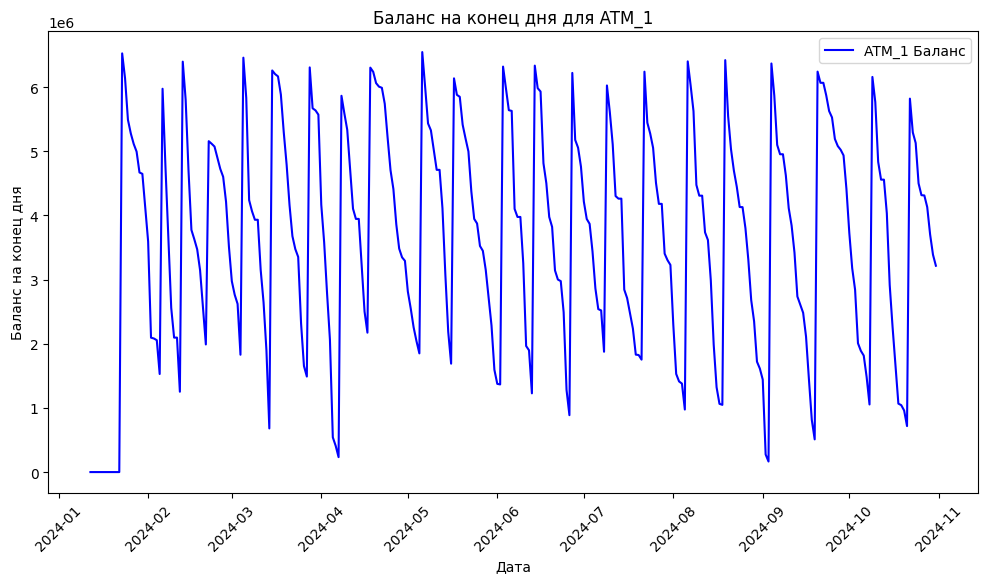

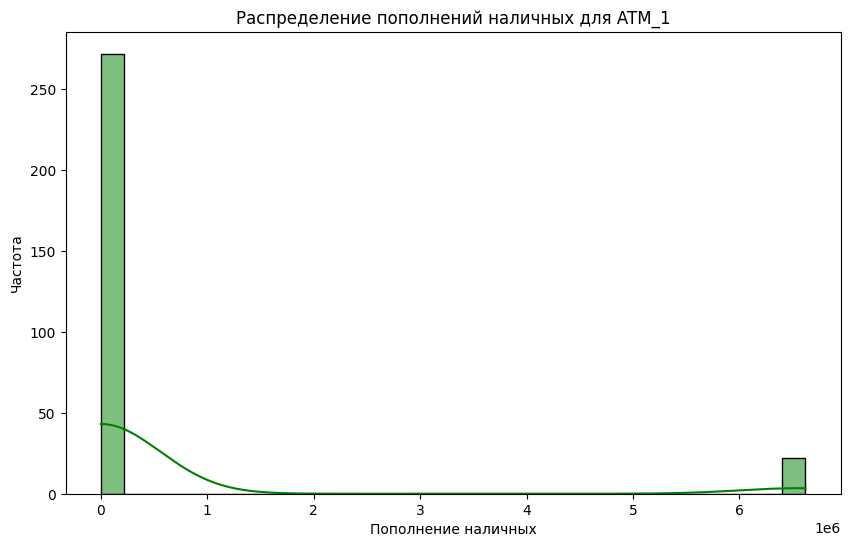

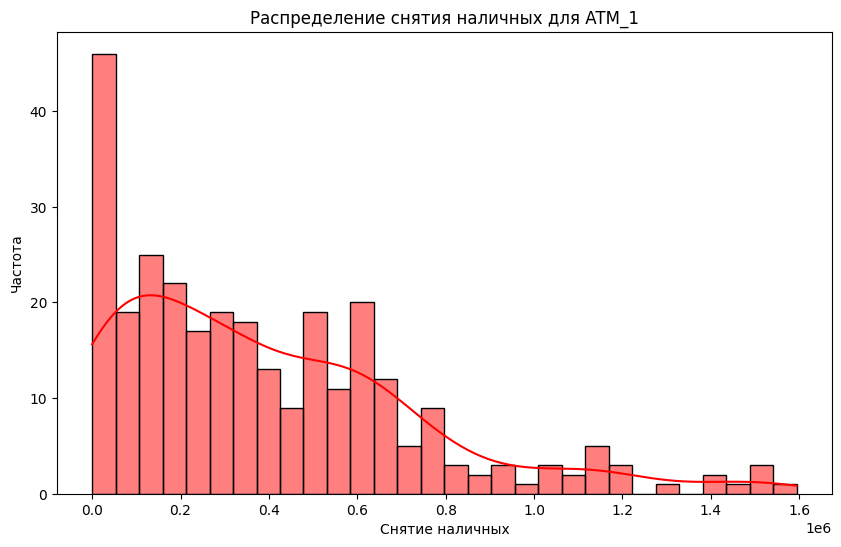

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Фильтруем данные для ATM_1
atm_1_data = transactions[transactions['ATM_ID'] == 'ATM_1']

# Анализ баланса на конец дня для ATM_1
plt.figure(figsize=(12, 6))
sns.lineplot(data=atm_1_data, x='date', y='bal_end_of_day', color='blue', label='ATM_1 Баланс')
plt.title('Баланс на конец дня для ATM_1')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.xticks(rotation=45)
plt.show()

# Гистограмма пополнений для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_1_data['cash_in'], kde=True, color='green', bins=30)
plt.title('Распределение пополнений наличных для ATM_1')
plt.xlabel('Пополнение наличных')
plt.ylabel('Частота')
plt.show()

# Гистограмма снятия наличных для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_1_data['cash_out'], kde=True, color='red', bins=30)
plt.title('Распределение снятия наличных для ATM_1')
plt.xlabel('Снятие наличных')
plt.ylabel('Частота')
plt.show()


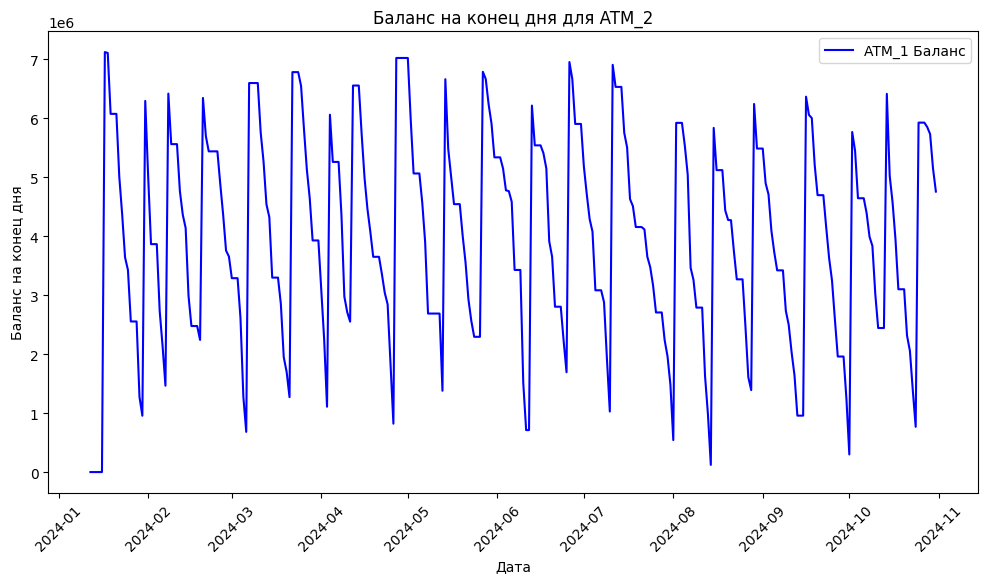

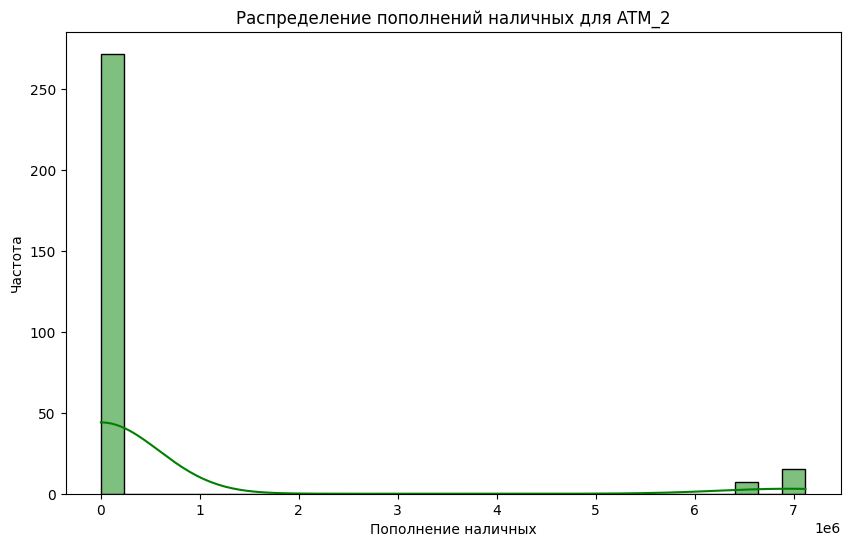

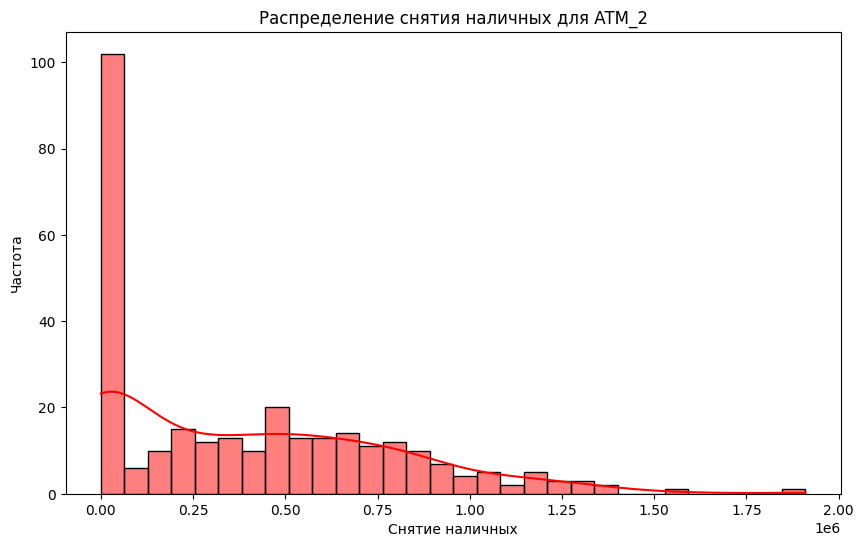

In [8]:
# Фильтруем данные для ATM_2
atm_2_data = transactions[transactions['ATM_ID'] == 'ATM_2']

# Анализ баланса на конец дня для ATM_1
plt.figure(figsize=(12, 6))
sns.lineplot(data=atm_2_data, x='date', y='bal_end_of_day', color='blue', label='ATM_1 Баланс')
plt.title('Баланс на конец дня для ATM_2')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.xticks(rotation=45)
plt.show()

# Гистограмма пополнений для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_2_data['cash_in'], kde=True, color='green', bins=30)
plt.title('Распределение пополнений наличных для ATM_2')
plt.xlabel('Пополнение наличных')
plt.ylabel('Частота')
plt.show()

# Гистограмма снятия наличных для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_2_data['cash_out'], kde=True, color='red', bins=30)
plt.title('Распределение снятия наличных для ATM_2')
plt.xlabel('Снятие наличных')
plt.ylabel('Частота')
plt.show()


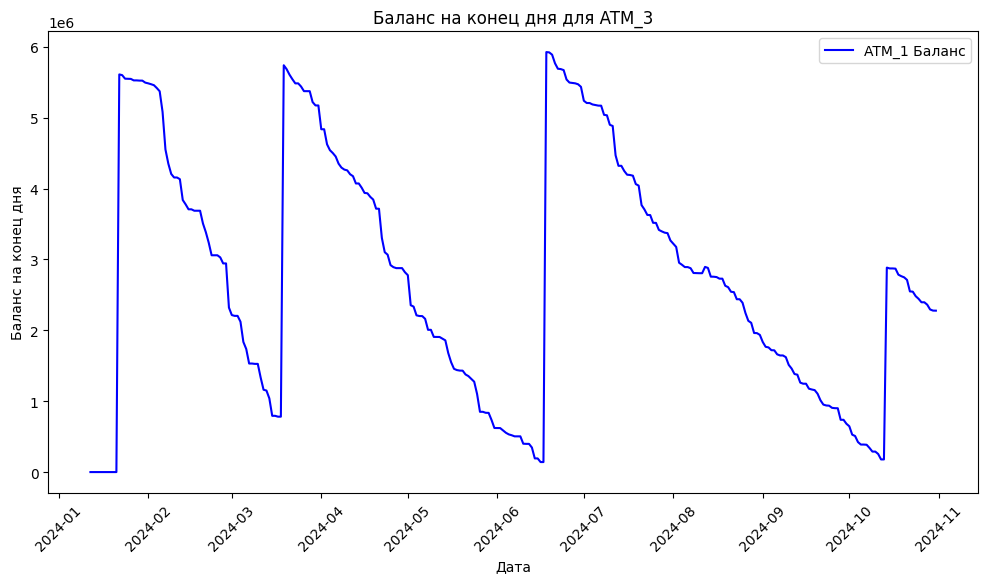

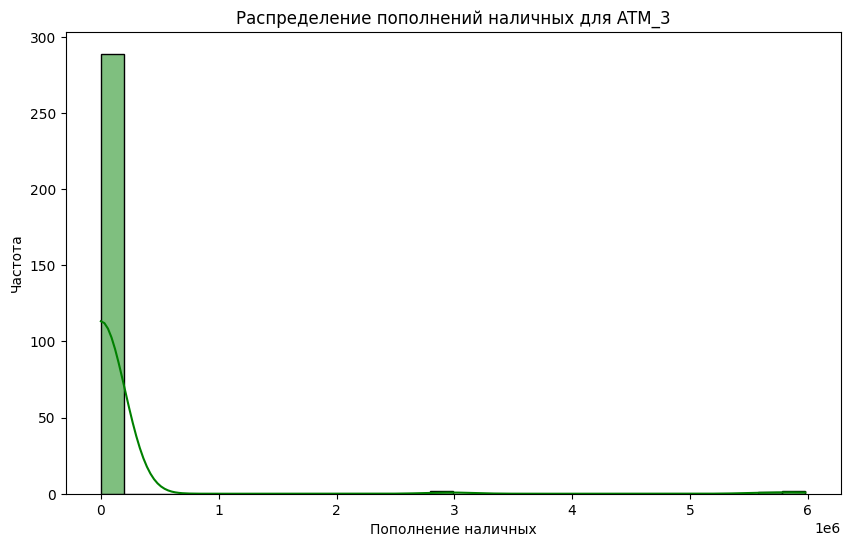

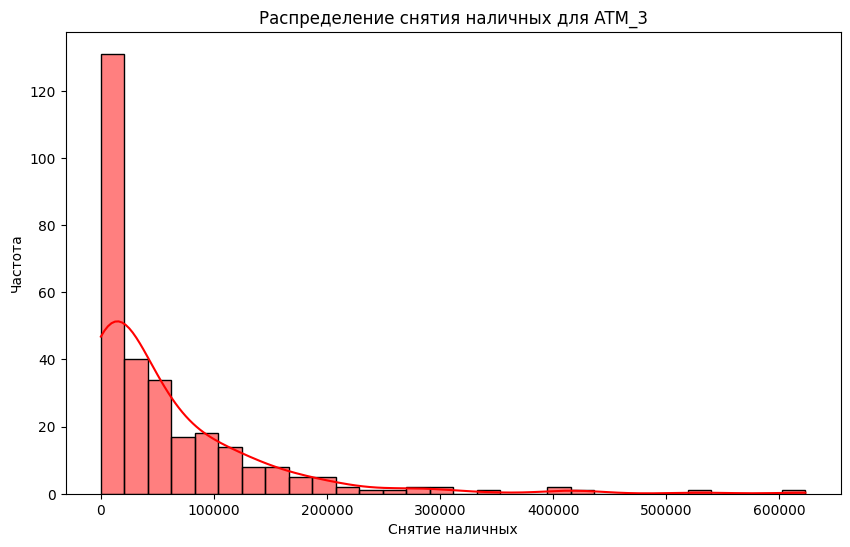

In [9]:
# Фильтруем данные для ATM_2
atm_3_data = transactions[transactions['ATM_ID'] == 'ATM_3']

# Анализ баланса на конец дня для ATM_1
plt.figure(figsize=(12, 6))
sns.lineplot(data=atm_3_data, x='date', y='bal_end_of_day', color='blue', label='ATM_1 Баланс')
plt.title('Баланс на конец дня для ATM_3')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.xticks(rotation=45)
plt.show()

# Гистограмма пополнений для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_3_data['cash_in'], kde=True, color='green', bins=30)
plt.title('Распределение пополнений наличных для ATM_3')
plt.xlabel('Пополнение наличных')
plt.ylabel('Частота')
plt.show()

# Гистограмма снятия наличных для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_3_data['cash_out'], kde=True, color='red', bins=30)
plt.title('Распределение снятия наличных для ATM_3')
plt.xlabel('Снятие наличных')
plt.ylabel('Частота')
plt.show()


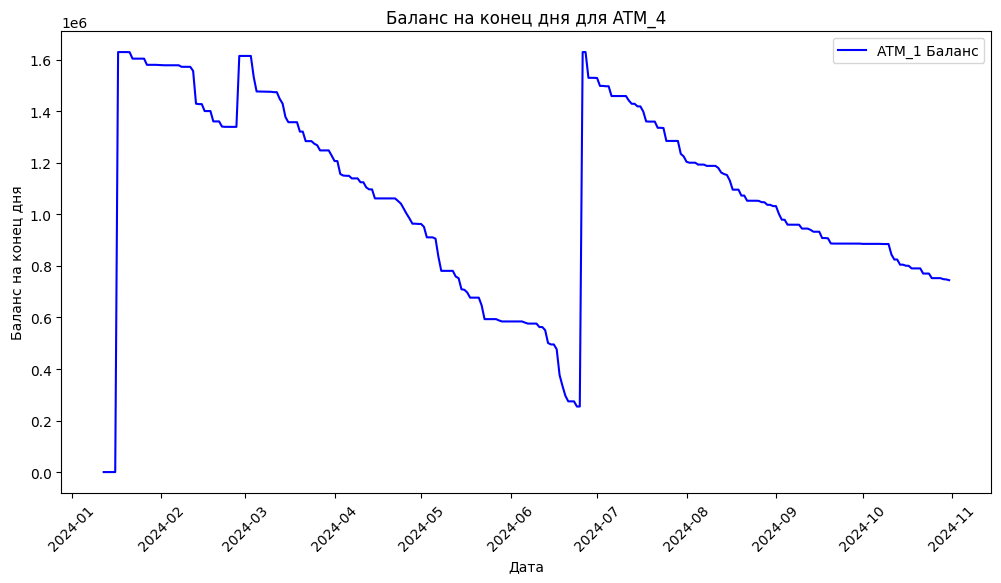

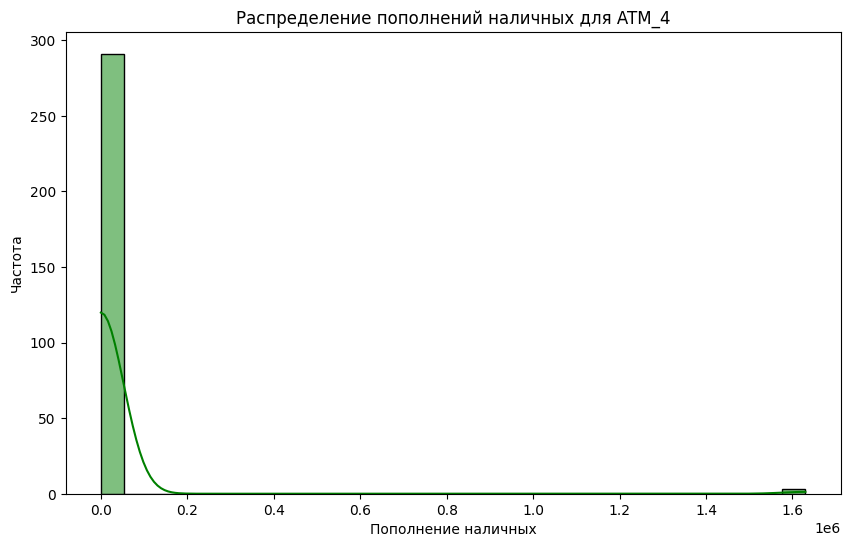

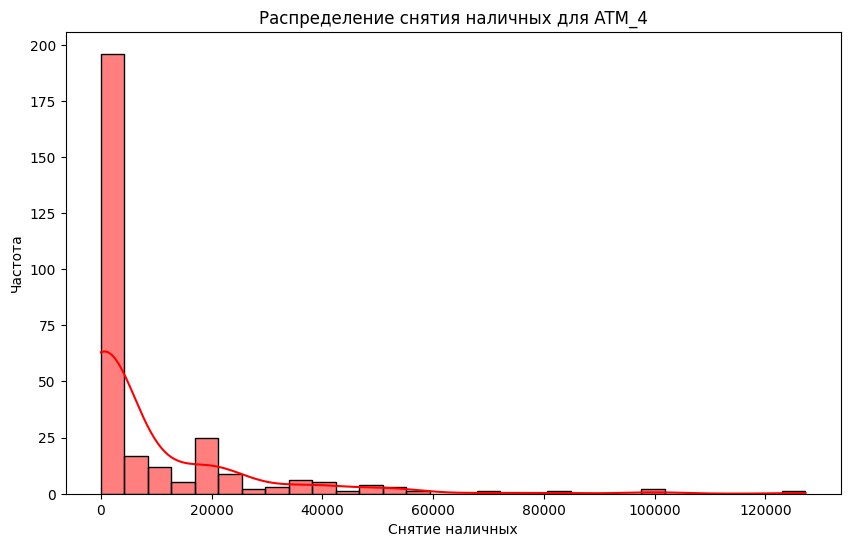

In [10]:
# Фильтруем данные для ATM_2
atm_4_data = transactions[transactions['ATM_ID'] == 'ATM_4']

# Анализ баланса на конец дня для ATM_1
plt.figure(figsize=(12, 6))
sns.lineplot(data=atm_4_data, x='date', y='bal_end_of_day', color='blue', label='ATM_1 Баланс')
plt.title('Баланс на конец дня для ATM_4')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.xticks(rotation=45)
plt.show()

# Гистограмма пополнений для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_4_data['cash_in'], kde=True, color='green', bins=30)
plt.title('Распределение пополнений наличных для ATM_4')
plt.xlabel('Пополнение наличных')
plt.ylabel('Частота')
plt.show()

# Гистограмма снятия наличных для ATM_1
plt.figure(figsize=(10, 6))
sns.histplot(atm_4_data['cash_out'], kde=True, color='red', bins=30)
plt.title('Распределение снятия наличных для ATM_4')
plt.xlabel('Снятие наличных')
plt.ylabel('Частота')
plt.show()


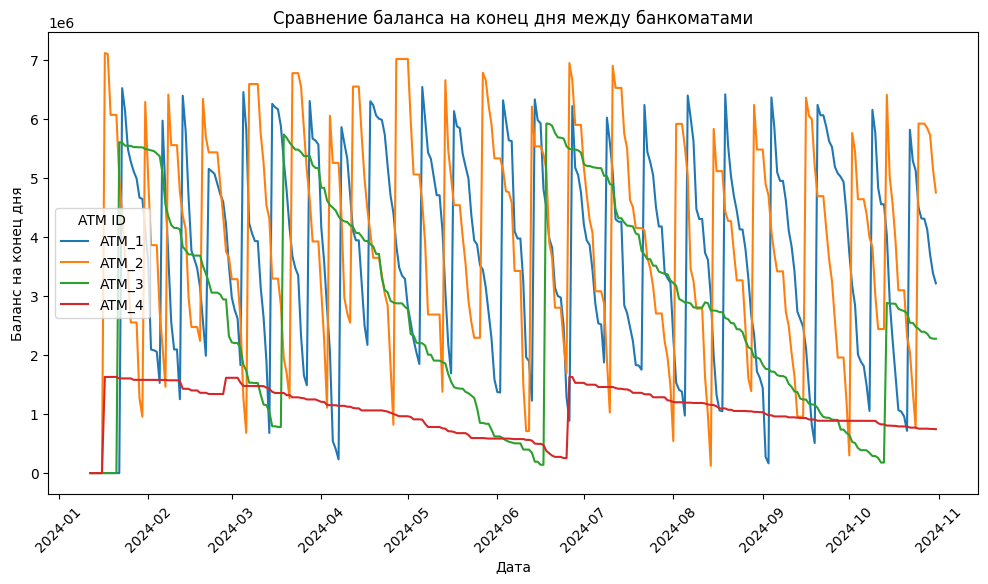

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=transactions, x='date', y='bal_end_of_day', hue='ATM_ID', palette='tab10')
plt.title('Сравнение баланса на конец дня между банкоматами')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.legend(title='ATM ID')
plt.xticks(rotation=45)
plt.show()


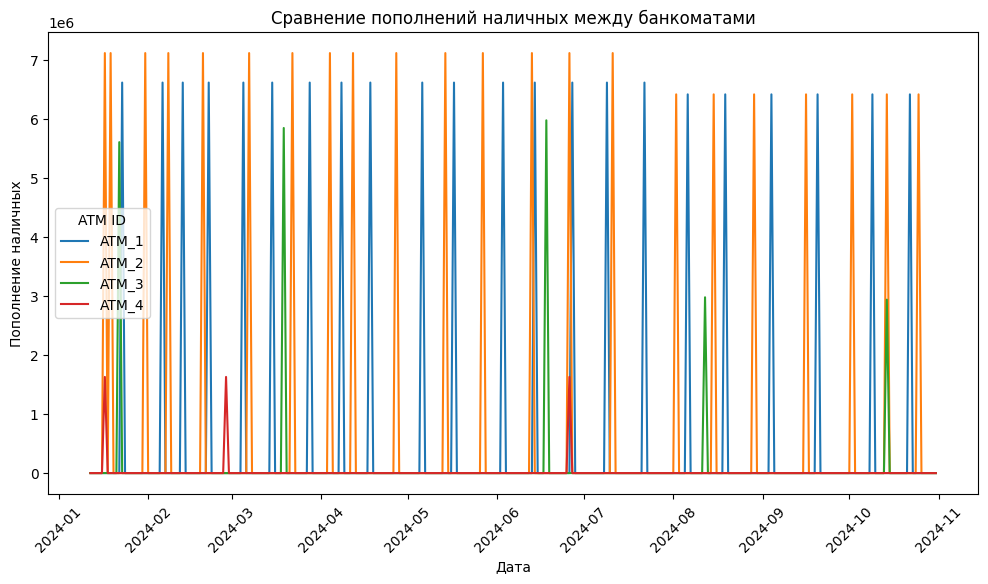

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=transactions, x='date', y='cash_in', hue='ATM_ID', palette='tab10')
plt.title('Сравнение пополнений наличных между банкоматами')
plt.xlabel('Дата')
plt.ylabel('Пополнение наличных')
plt.legend(title='ATM ID')
plt.xticks(rotation=45)
plt.show()


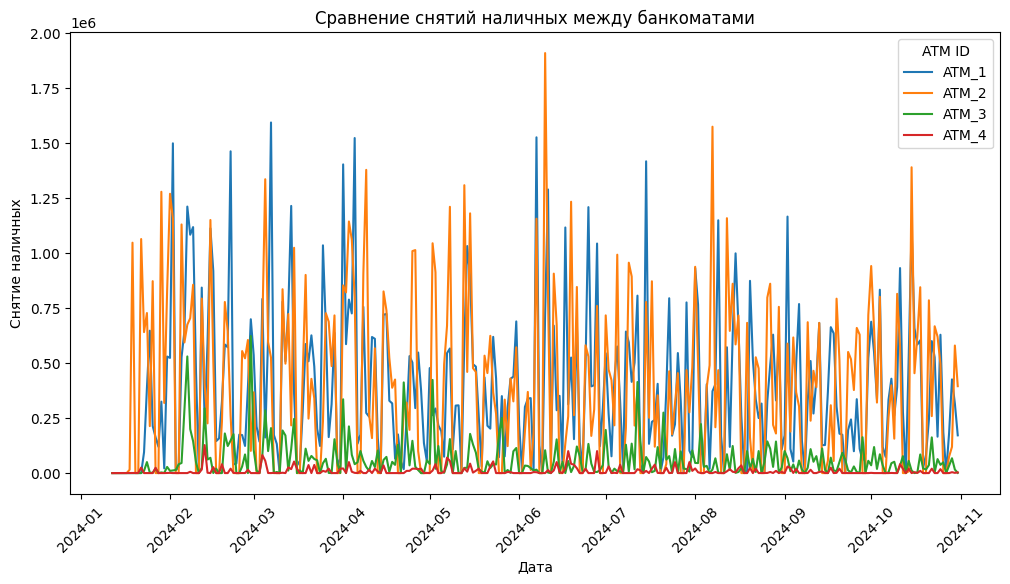

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=transactions, x='date', y='cash_out', hue='ATM_ID', palette='tab10')
plt.title('Сравнение снятий наличных между банкоматами')
plt.xlabel('Дата')
plt.ylabel('Снятие наличных')
plt.legend(title='ATM ID')
plt.xticks(rotation=45)
plt.show()


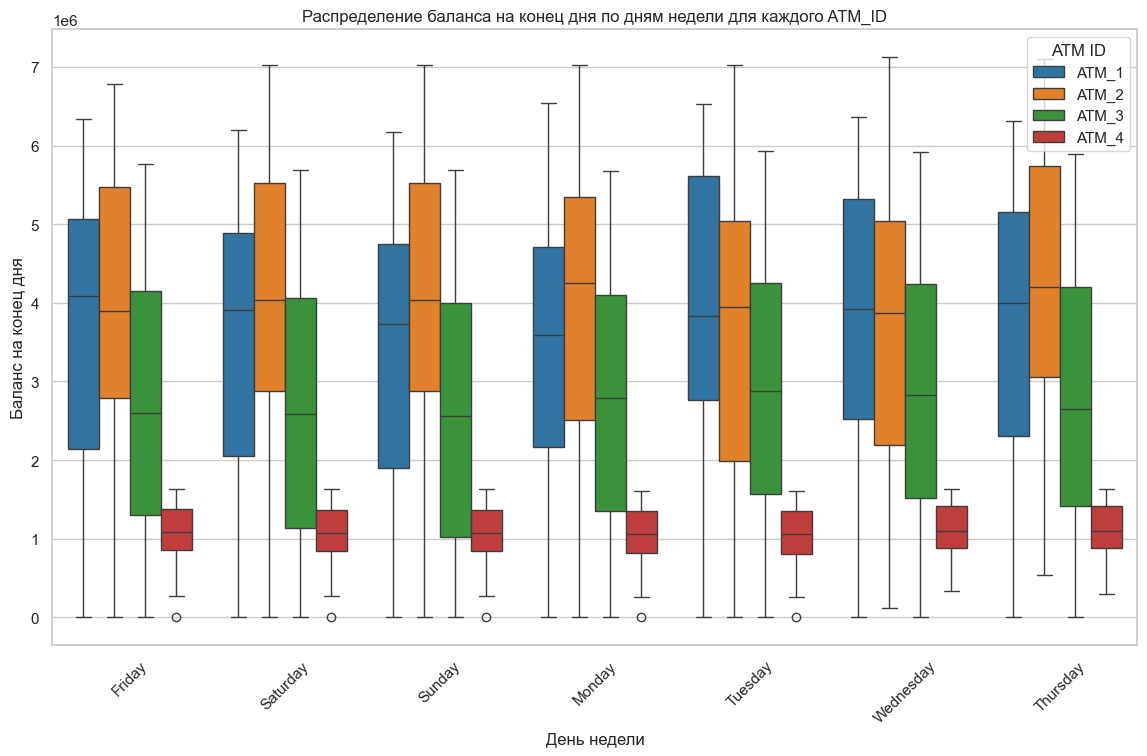

In [14]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['day_of_week'] = transactions['date'].dt.dayofweek
transactions['day_of_week_name'] = transactions['date'].dt.strftime('%A')


sns.set(style="whitegrid")

# Построение распределение баланса на конец дня по дням недели для каждого банкомата
plt.figure(figsize=(14, 8))
sns.boxplot(data=transactions, x='day_of_week_name', y='bal_end_of_day', hue='ATM_ID', palette='tab10')
plt.title('Распределение баланса на конец дня по дням недели для каждого ATM_ID')
plt.xlabel('День недели')
plt.ylabel('Баланс на конец дня')
plt.xticks(rotation=45)
plt.legend(title='ATM ID')
plt.show()


### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt


# Пример функции для предобработки данных
def preprocess_data(rate_dict, transactions, fees):
    df = transactions
    df['lost_profits'] = calculate_missed_income(rate_dict, transactions)
    df['incassation_cost'] = calculate_incassation_cost(transactions, fees)
    
    # Сдвиговые признаки: для каждого банкомата, например, за последние 3 дня
    for i in range(1, 4):
        df[f'bal_end_of_day_lag_{i}'] = df.groupby('ATM_ID')['bal_end_of_day'].shift(i)
        df[f'cash_out_lag_{i}'] = df.groupby('ATM_ID')['cash_out'].shift(i)
        df[f'cash_in_lag_{i}'] = df.groupby('ATM_ID')['cash_in'].shift(i)
        
    # Заполнение пропущенных значений (например, если не было данных за предыдущие дни)
    df.fillna(0, inplace=True)
    
    return df

# Загрузка данных (пример)
# Предположим, что у нас есть DataFrame с данными транзакций
# df = pd.read_csv('transactions.csv')  # Замените на путь к вашему файлу
# Для примера создадим данные
np.random.seed(42)



# Предобработка данных
df_prep = preprocess_data(rate_dict, transactions, fees)

atm_3_data = df_prep[df_prep['ATM_ID'] == 'ATM_1']
df = atm_3_data.drop('ATM_ID', axis = 1)

# Разделение на признаки и целевую переменную
X = df.drop(columns=['date', 'date_only', 'day_of_week', 'day_of_week_name',  'cash_in'])  # Используем все столбцы, кроме даты и целевой переменной
y = df['cash_in']  # Целевая переменная - сумма пополнений

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Обучение модели XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)


# Оптимизация на основе упущенной прибыли и стоимости инкассации
def evaluate_model(df, model):
    df['predicted_cash_in'] = model.predict(df.drop(columns=['date', 'date_only', 'day_of_week', 'day_of_week_name',  'ATM_ID', 'cash_in']))
    df['cash_in'] = df['predicted_cash_in']
    df['predicted_lost_profits'] = calculate_missed_income(rate_dict, df)
    df['predicted_incassation_cost'] = calculate_incassation_cost(df, fees)
    
    # Проверяем, сколько раз баланс на конец дня больше, чем снятие наличных
    df['balance_check'] = (df['bal_end_of_day'] >= df['cash_out']).astype(int)
    service_level = df['balance_check'].mean()  # Это и есть процент случаев, когда баланс больше cash_out
    print(f'Service Level (bal_end_of_day >= cash_out): {service_level * 100:.2f}%')

    # Суммарная упущенная прибыль и стоимость инкассации
    total_lost_profits = df['predicted_lost_profits'].sum()
    total_incassation_cost = df['predicted_incassation_cost'].sum()
    print(f'Total Losts from Lost Profits and Incassaion cost after using model: {total_lost_profits:.2f}, {total_incassation_cost:.2f}')
    

# Оценка модели на тестовых данных
evaluate_model(atm_3_data, model)
print(f'Total Losts from Lost Profits and Incassaion cost before using model: {total_lost_profits_firstly_1:.2f}, {total_incassation_cost_firstly_1:.2f}')

Service Level (bal_end_of_day >= cash_out): 98.98%
Total Losts from Lost Profits and Incassaion cost after using model: 356945.71, 104198.77
Total Losts from Lost Profits and Incassaion cost after using model: 356945.71, 44474.00


/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_5044/2860517131.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cash_in'] = model.predict(df.drop(columns=['date', 'date_only', 'day_of_week', 'day_of_week_name',  'ATM_ID', 'cash_in']))
/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_5044/2860517131.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cash_in'] = df['predicted_cash_in']
/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_5044/1447513946.py:5